In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Importing Necessary Libraries

In [2]:
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
mtir=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
dinfo=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
bt=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")
cb=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")
ct=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv")
book=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
bb=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")
sample=pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

# Data Exploration

In [4]:
print(mtir.info())
mtir.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_theater_id  150 non-null    object
 1   cine_theater_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB
None


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


In [5]:
print(dinfo.info())
dinfo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_date    547 non-null    object
 1   day_of_week  547 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB
None


,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


In [6]:
print(bt.info())
bt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_theater_id  314 non-null    object 
 1   theater_type     829 non-null    object 
 2   theater_area     829 non-null    object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB
None


,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


In [7]:
print(cb.info())
cb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   cine_theater_id   1641966 non-null  object
 1   show_datetime     1641966 non-null  object
 2   booking_datetime  1641966 non-null  object
 3   tickets_sold      1641966 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 50.1+ MB
None


,cine_theater_id,show_datetime,booking_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13


In [8]:
print(ct.info())
ct.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB
None


,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


In [9]:
print(book.info())
book.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB
None


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


In [10]:
print(bb.info())
bb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_theater_id   68336 non-null  object
 1   show_datetime     68336 non-null  object
 2   booking_datetime  68336 non-null  object
 3   tickets_booked    68336 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB
None


,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


In [11]:
print(sample.info())
sample.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              38062 non-null  object
 1   audience_count  38062 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 594.8+ KB
None


,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


# Data Preparation

In [12]:
target_col = "audience_count"
np.random.seed(42)


book["show_date"] = pd.to_datetime(book["show_date"])
book = book.sort_values(["book_theater_id", "show_date"]).reset_index(drop=True)


def parse_id(s):
    parts = str(s).split("_")
    book_id = f"{parts[0]}_{parts[1]}"
    date_str = parts[-1]
    return book_id, pd.to_datetime(date_str)

parsed = sample["ID"].apply(parse_id)
sample["book_theater_id"] = parsed.apply(lambda x: x[0])
sample["show_date"] = parsed.apply(lambda x: x[1])

test_dates = sorted(sample["show_date"].unique())
min_test_date = min(test_dates)
max_test_date = max(test_dates)
print(f"Test range: {min_test_date} to {max_test_date}")

# AGGREGATE BOOKNOW BOOKING DATA (bb)
bb["show_datetime"] = pd.to_datetime(bb["show_datetime"])
bb["booking_datetime"] = pd.to_datetime(bb["booking_datetime"])
bb["show_date"] = bb["show_datetime"].dt.date
bb["booking_date"] = bb["booking_datetime"].dt.date

# Calculating lead time (days between booking and show)
bb["lead_time_days"] = (bb["show_datetime"] - bb["booking_datetime"]).dt.total_seconds() / 86400

# Aggregating booking features by theater and show_date
bb_agg = bb.groupby(["book_theater_id", "show_date"]).agg({
    "tickets_booked": "sum",
    "lead_time_days": ["mean", "std", "min", "max"]
}).reset_index()

bb_agg.columns = ["book_theater_id", "show_date", "bb_tickets_booked", 
                  "bb_lead_mean", "bb_lead_std", "bb_lead_min", "bb_lead_max"]

# Convert show_date back to datetime
bb_agg["show_date"] = pd.to_datetime(bb_agg["show_date"])

# AGGREGATE CINEPOS BOOKING DATA (cb) via mapping
cb["show_datetime"] = pd.to_datetime(cb["show_datetime"])
cb["booking_datetime"] = pd.to_datetime(cb["booking_datetime"])
cb["show_date"] = cb["show_datetime"].dt.date
cb["lead_time_days"] = (cb["show_datetime"] - cb["booking_datetime"]).dt.total_seconds() / 86400

# Map cinePOS theaters to booknow theaters
# Strategy: aggregate at cine level first, then join to book via mtir
cb_agg = cb.groupby(["cine_theater_id", "show_date"]).agg({
    "tickets_sold": "sum",
    "lead_time_days": ["mean", "std"]
}).reset_index()

cb_agg.columns = ["cine_theater_id", "show_date", "cb_tickets_sold", 
                  "cb_lead_mean", "cb_lead_std"]
cb_agg["show_date"] = pd.to_datetime(cb_agg["show_date"])

# Join to mapping (one book -> many cine, so we'll aggregate cine data)
cb_mapped = mtir.merge(cb_agg, on="cine_theater_id", how="left")

# Aggregate multiple cinePOS theaters mapped to same book_theater
cb_book_agg = cb_mapped.groupby(["book_theater_id", "show_date"]).agg({
    "cb_tickets_sold": "sum",
    "cb_lead_mean": "mean",
    "cb_lead_std": "mean"
}).reset_index()



# CREATE FULL TIMELINE (TRAIN + TEST PLACEHOLDER)

# Placeholder for test rows
sample_stub = sample[["book_theater_id", "show_date"]].drop_duplicates().reset_index(drop=True)

# Create placeholder with all columns
placeholder = sample_stub.copy()
for c in book.columns:
    if c not in placeholder.columns:
        placeholder[c] = np.nan

placeholder = placeholder[book.columns]

# Concatenate
full = pd.concat([book, placeholder], ignore_index=True, sort=False)
full = full.sort_values(["book_theater_id", "show_date"]).reset_index(drop=True)

# MERGE BOOKING FEATURES
full = full.merge(bb_agg, on=["book_theater_id", "show_date"], how="left")
full = full.merge(cb_book_agg, on=["book_theater_id", "show_date"], how="left")

# Fill booking NaNs with 0 (theaters with no bookings)
booking_cols = ["bb_tickets_booked", "bb_lead_mean", "bb_lead_std", "bb_lead_min", "bb_lead_max",
                "cb_tickets_sold", "cb_lead_mean", "cb_lead_std"]
for col in booking_cols:
    if col in full.columns:
        full[col] = full[col].fillna(0)


Test range: 2024-03-01 00:00:00 to 2024-04-22 00:00:00


# Feature Engineering

In [13]:
# Date Features
dinfo["show_date"] = pd.to_datetime(dinfo["show_date"])
full = full.merge(dinfo, on="show_date", how="left")

day_map = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, 
           "Friday": 4, "Saturday": 5, "Sunday": 6}
full["dayofweek"] = full["day_of_week"].map(day_map).astype("int8")
full["is_weekend"] = (full["dayofweek"] >= 5).astype(np.int8)
full["month"] = full["show_date"].dt.month.astype(np.int8)
full["year"] = full["show_date"].dt.year.astype(np.int16)


import holidays
india_holidays = holidays.India()
full["is_holiday"] = full["show_date"].apply(lambda x: x in india_holidays).astype(int)

full["is_month_start"] = full["show_date"].dt.is_month_start.astype("int8")
full["is_month_end"] = full["show_date"].dt.is_month_end.astype("int8")
full["is_quarter_start"] = full["show_date"].dt.is_quarter_start.astype("int8")
full["is_quarter_end"] = full["show_date"].dt.is_quarter_end.astype("int8")
full["day_of_month"] = full["show_date"].dt.day.astype("int8")
full["day_of_year"] = full["show_date"].dt.dayofyear.astype("int16")
full["week_of_year"] = full["show_date"].dt.isocalendar().week.astype("int16")

full["is_long_weekend"] = (
    full["show_date"].dt.dayofweek.isin([4, 5, 6]) & 
    (full["is_holiday"] == 1)
).astype(int)


In [14]:
# Merging theater metadata
for col in ["latitude", "longitude"]:
    if col in bt.columns:
        bt[col] = bt[col].astype("float32")

full = full.merge(
    bt[["book_theater_id", "theater_type", "theater_area", "latitude", "longitude"]],
    on="book_theater_id",
    how="left"
)

# Geographic clustering
if all(c in full.columns for c in ["latitude", "longitude"]):
    theater_coords = (
        full[["book_theater_id", "latitude", "longitude"]]
        .drop_duplicates("book_theater_id")
        .dropna()
        .reset_index(drop=True)
    )
    
    X = theater_coords[["latitude", "longitude"]].astype("float32").values
    N_CLUSTERS = 9
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init="auto")
    theater_coords["geo_cluster"] = kmeans.fit_predict(X)
    
    full = full.merge(
        theater_coords[["book_theater_id", "geo_cluster"]],
        on="book_theater_id",
        how="left"
    )
    
    full["geo_cluster"] = full["geo_cluster"].fillna(-1).astype("int8")

# Encoding categorical theater features
for col in ["theater_type", "theater_area"]:
    if col in full.columns:
        le_temp = LabelEncoder()
        full[col] = le_temp.fit_transform(full[col].astype(str))


# EDA

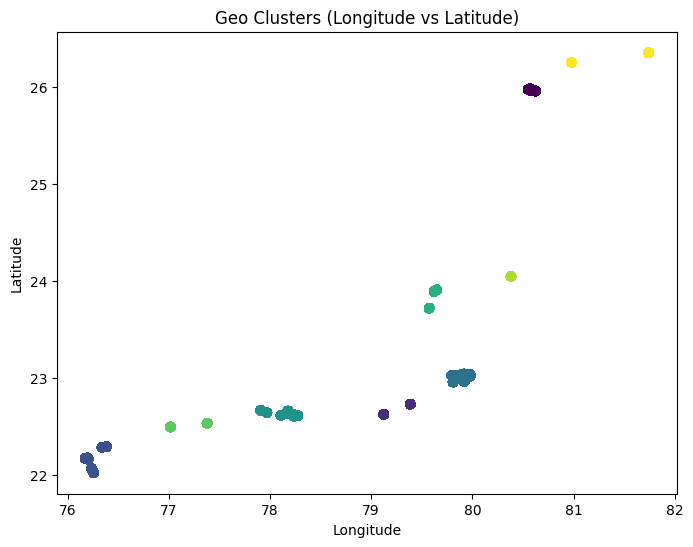

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    full["longitude"], 
    full["latitude"], 
    c=full["geo_cluster"], 
    s=40
)
plt.title("Geo Clusters (Longitude vs Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


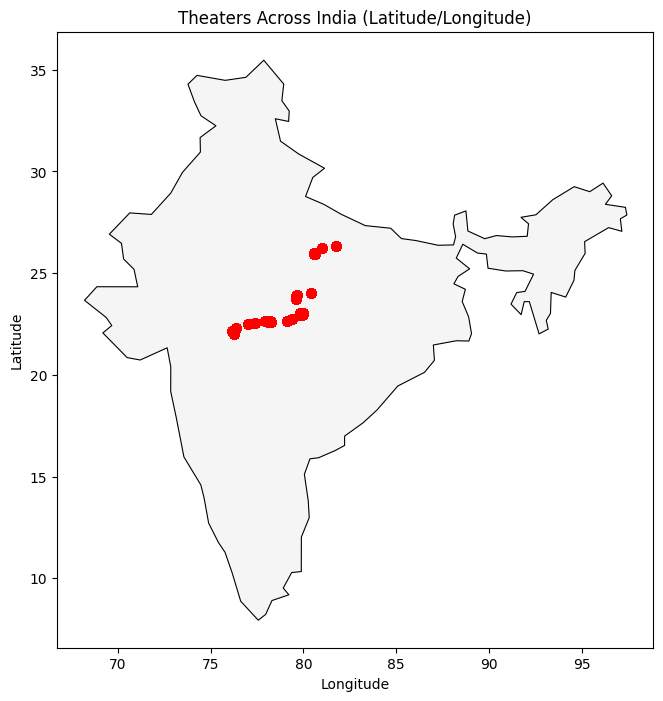

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

india = world[world['name'] == 'India']

gdf = gpd.GeoDataFrame(
    full,
    geometry=gpd.points_from_xy(full['longitude'], full['latitude']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(8,8))

india.plot(ax=ax, color="whitesmoke", edgecolor="black", linewidth=0.8)

gdf.plot(
    ax=ax,
    color="red",
    markersize=40,
    alpha=0.8
)

plt.title("Theaters Across India (Latitude/Longitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [17]:
# Lag and Rolling features

lags = [1, 2, 3, 7, 14, 21, 28]
for lag in lags:
    full[f"lag_{lag}"] = full.groupby("book_theater_id")[target_col].shift(lag)

for window in [7, 14, 28]:
    full[f"rolling_mean_{window}"] = (
        full.groupby("book_theater_id")[target_col]
        .shift(1)
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    full[f"rolling_std_{window}"] = (
        full.groupby("book_theater_id")[target_col]
        .shift(1)
        .rolling(window=window, min_periods=1)
        .std()
        .reset_index(level=0, drop=True)
    )

# Booking trend features
for col in ["bb_tickets_booked", "cb_tickets_sold"]:
    if col in full.columns:
        full[f"{col}_roll7"] = (
            full.groupby("book_theater_id")[col]
            .shift(1)
            .rolling(window=7, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )

In [18]:
# Calculating theater-level statistics from training data only
train_mask_stats = (~full[target_col].isna()) & (full["show_date"] < min_test_date)
theater_stats = full[train_mask_stats].groupby("book_theater_id")[target_col].agg([
    "mean", "std", "min", "max", "median"
]).reset_index()
theater_stats.columns = ["book_theater_id", "theater_mean_aud", "theater_std_aud", 
                         "theater_min_aud", "theater_max_aud", "theater_median_aud"]

full = full.merge(theater_stats, on="book_theater_id", how="left")


# Get training data for clustering
train_data = full[train_mask_stats].copy()

# Create comprehensive trend features for each theater
def create_theater_trend_features(df):
    """Extract trend characteristics for each theater"""
    
    theater_features = []
    
    for theater_id in df["book_theater_id"].unique():
        theater_df = df[df["book_theater_id"] == theater_id].sort_values("show_date")
        
        if len(theater_df) < 7:  # Need minimum data
            continue
            
        features = {"book_theater_id": theater_id}
        
        # Basic statistics
        features["mean_audience"] = theater_df[target_col].mean()
        features["std_audience"] = theater_df[target_col].std()
        features["cv_audience"] = features["std_audience"] / (features["mean_audience"] + 1)  # Coefficient of variation
        features["max_audience"] = theater_df[target_col].max()
        features["min_audience"] = theater_df[target_col].min()
        
        # Trend slope (linear regression coefficient)
        from scipy.stats import linregress
        x = np.arange(len(theater_df))
        slope, intercept, r_value, p_value, std_err = linregress(x, theater_df[target_col].values)
        features["trend_slope"] = slope
        features["trend_r2"] = r_value ** 2
        
        # Weekend vs Weekday patterns
        weekend_mask = theater_df["show_date"].dt.dayofweek >= 5
        features["weekend_mean"] = theater_df[weekend_mask][target_col].mean() if weekend_mask.sum() > 0 else 0
        features["weekday_mean"] = theater_df[~weekend_mask][target_col].mean() if (~weekend_mask).sum() > 0 else 0
        features["weekend_ratio"] = features["weekend_mean"] / (features["weekday_mean"] + 1)
        
        # Monthly patterns (peak month)
        monthly_avg = theater_df.groupby(theater_df["show_date"].dt.month)[target_col].mean()
        features["peak_month"] = monthly_avg.idxmax() if len(monthly_avg) > 0 else 1
        features["peak_month_ratio"] = monthly_avg.max() / (monthly_avg.mean() + 1) if len(monthly_avg) > 0 else 1
        
        # Seasonality strength (ratio of max monthly avg to min monthly avg)
        features["seasonality_strength"] = monthly_avg.max() / (monthly_avg.min() + 1) if len(monthly_avg) > 1 else 1
        
        # Volatility measures
        features["iqr"] = theater_df[target_col].quantile(0.75) - theater_df[target_col].quantile(0.25)
        features["range"] = features["max_audience"] - features["min_audience"]
        
        # Growth rate (recent vs early period)
        mid_point = len(theater_df) // 2
        early_mean = theater_df.iloc[:mid_point][target_col].mean()
        recent_mean = theater_df.iloc[mid_point:][target_col].mean()
        features["growth_rate"] = (recent_mean - early_mean) / (early_mean + 1)
        
        # Autocorrelation (lag 1 and lag 7)
        features["autocorr_lag1"] = theater_df[target_col].autocorr(lag=1) if len(theater_df) > 1 else 0
        features["autocorr_lag7"] = theater_df[target_col].autocorr(lag=7) if len(theater_df) > 7 else 0
        
        theater_features.append(features)
    
    return pd.DataFrame(theater_features)

theater_trend_df = create_theater_trend_features(train_data)

# Prepare features for clustering (normalize them)
from sklearn.preprocessing import StandardScaler

cluster_features = [
    "mean_audience", "std_audience", "cv_audience",
    "trend_slope", "trend_r2",
    "weekend_ratio", "seasonality_strength",
    "growth_rate", "iqr", "autocorr_lag1", "autocorr_lag7"
]

# Handle any NaN/inf values
theater_trend_df = theater_trend_df.replace([np.inf, -np.inf], np.nan)
for col in cluster_features:
    theater_trend_df[col] = theater_trend_df[col].fillna(theater_trend_df[col].median())

# Standardize features
scaler = StandardScaler()
X_cluster = scaler.fit_transform(theater_trend_df[cluster_features])

# Perform clustering
N_TREND_CLUSTERS = 6
kmeans_trend = KMeans(n_clusters=N_TREND_CLUSTERS, random_state=42, n_init=20, max_iter=500)
theater_trend_df["trend_cluster"] = kmeans_trend.fit_predict(X_cluster)


# Merge trend clusters back to full dataset
full = full.merge(
    theater_trend_df[["book_theater_id", "trend_cluster"]],
    on="book_theater_id",
    how="left"
)

# Fill missing trend clusters (theaters not in training) with -1
full["trend_cluster"] = full["trend_cluster"].fillna(-1).astype("int8")

# Create cluster-level features (mean audience per cluster per day)
cluster_day_stats = train_data.merge(
    theater_trend_df[["book_theater_id", "trend_cluster"]],
    on="book_theater_id",
    how="left"
)

cluster_day_means = cluster_day_stats.groupby(["trend_cluster", "dayofweek"])[target_col].mean().reset_index()
cluster_day_means.columns = ["trend_cluster", "dayofweek", "cluster_day_mean"]

full = full.merge(cluster_day_means, on=["trend_cluster", "dayofweek"], how="left")
full["cluster_day_mean"] = full["cluster_day_mean"].fillna(full["cluster_day_mean"].median())



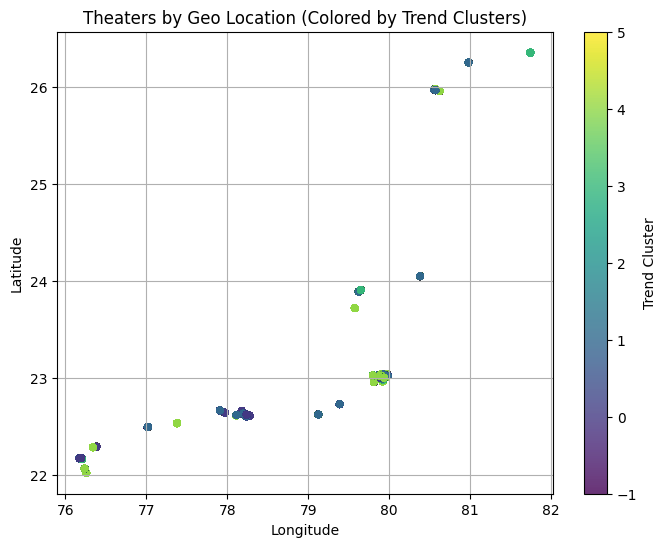

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Scatter of theatres on the map
plt.scatter(
    full['longitude'], 
    full['latitude'], 
    c=full['trend_cluster'],   # color by TREND clusters
    s=20,                    # point size
    alpha=0.8
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Theaters by Geo Location (Colored by Trend Clusters)")
plt.colorbar(label="Trend Cluster")
plt.grid(True)
plt.show()


In [20]:
# Fill lag/rolling NaNs with 0
lag_roll_cols = [c for c in full.columns if c.startswith(("lag_", "rolling_"))]

for col in lag_roll_cols:
    full[col] = full.groupby("book_theater_id")[col].transform(
        lambda x: x.fillna(x.median())
    )

# Fill theater stat NaNs with MEDIAN 
theater_stat_cols = [
    "theater_mean_aud", 
    "theater_std_aud", 
    "theater_min_aud", 
    "theater_max_aud", 
    "theater_median_aud"
]

for col in theater_stat_cols:
    if col in full.columns:
        full[col] = full[col].fillna(full[col].median())



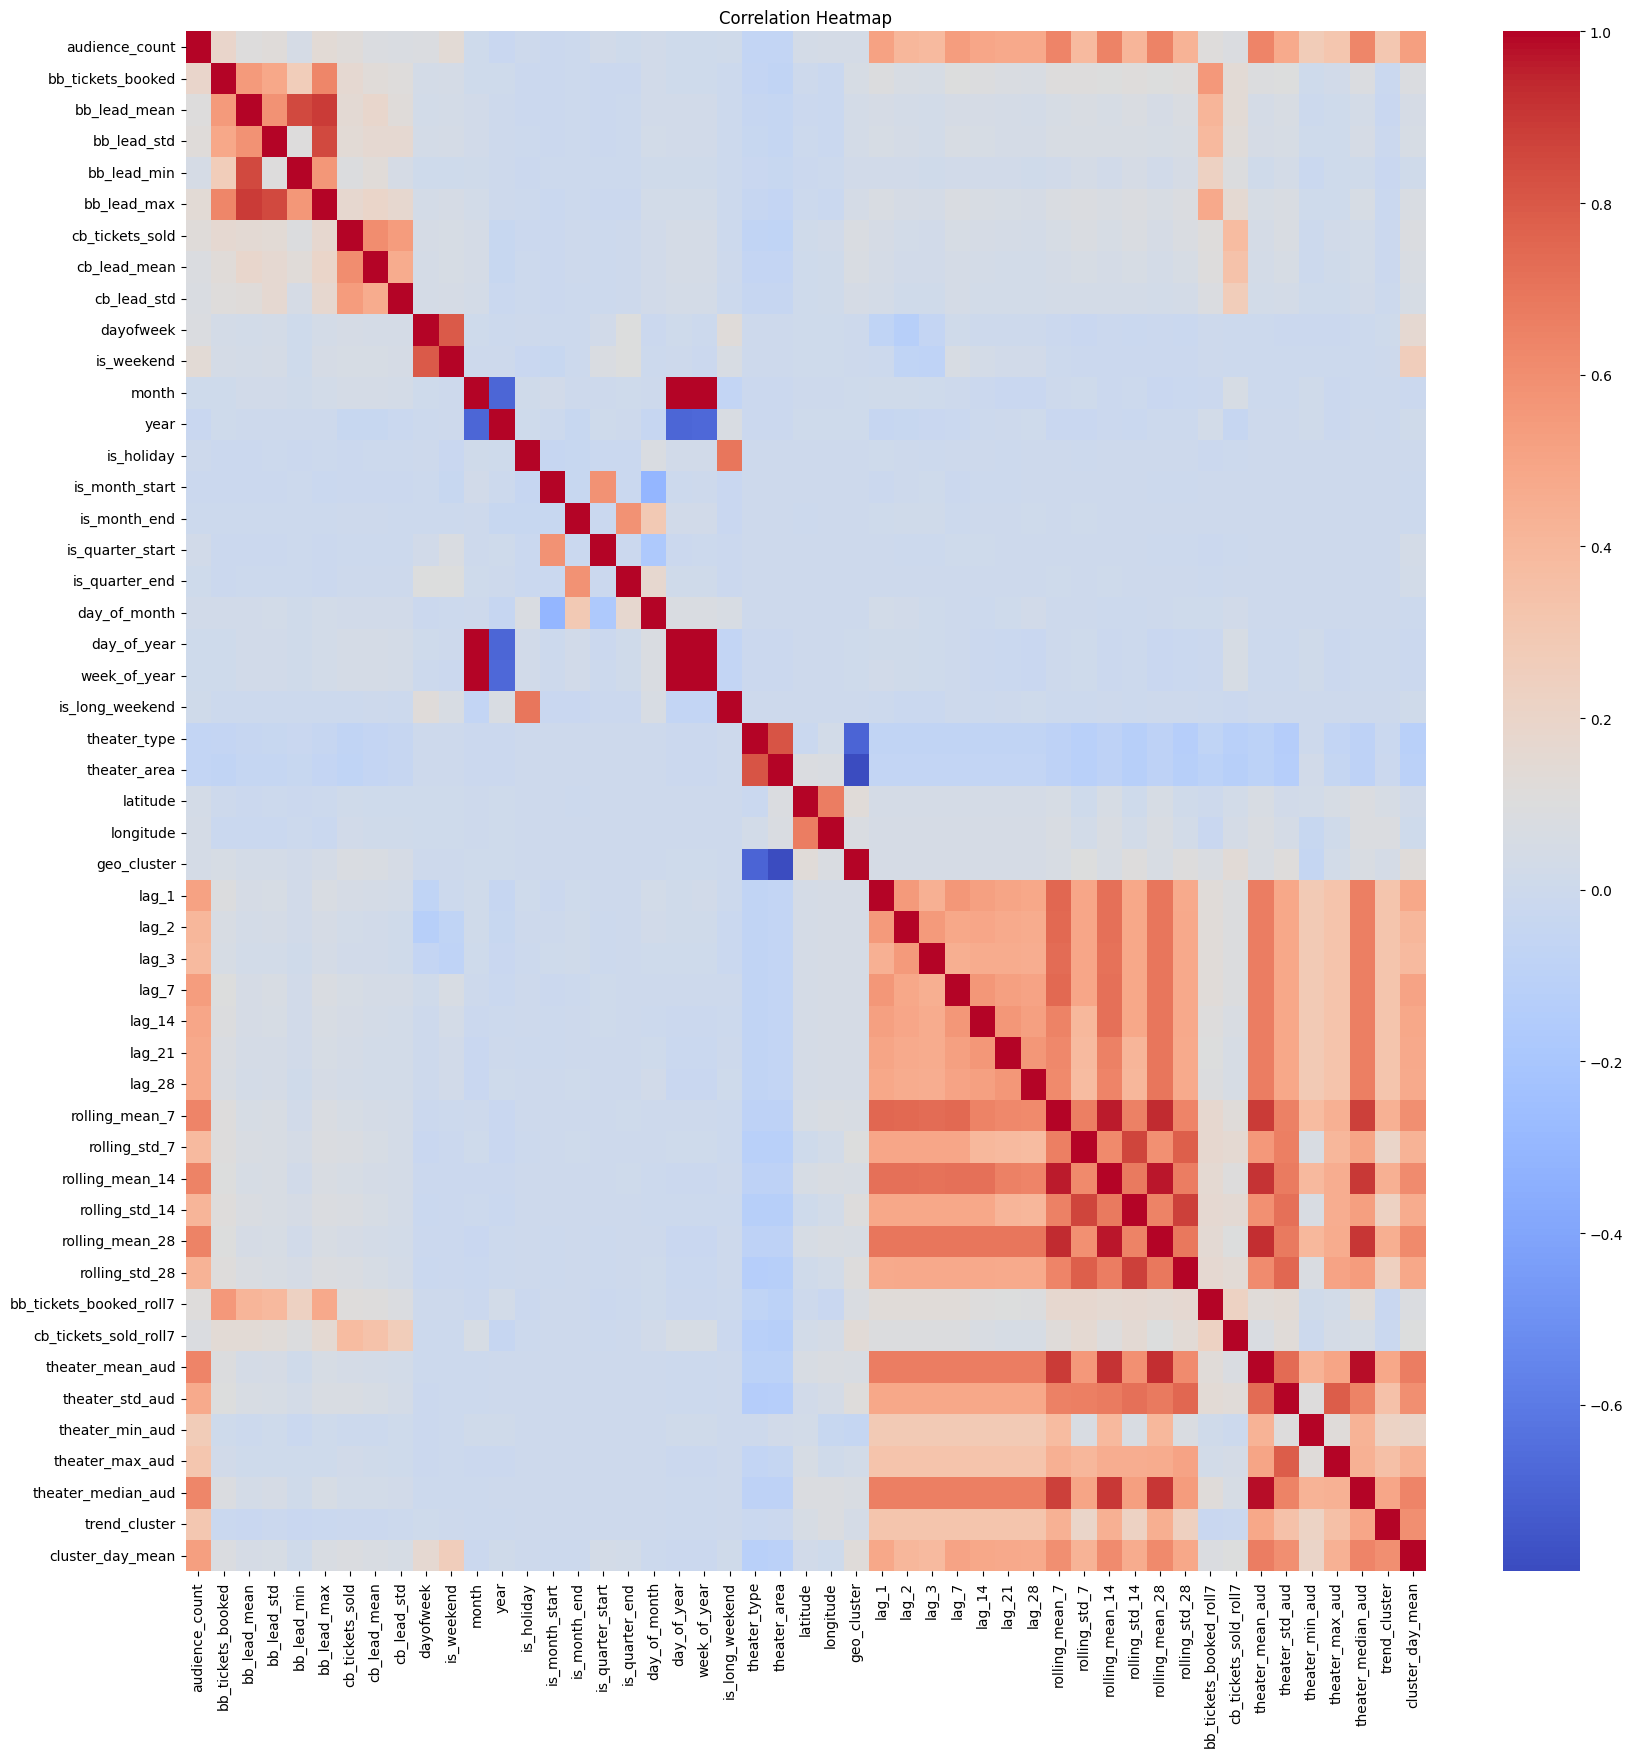

In [21]:
import seaborn as sns

# Select only numeric columns
num_cols = full.select_dtypes(include=['number'])

plt.figure(figsize=(20, 20))
sns.heatmap(num_cols.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


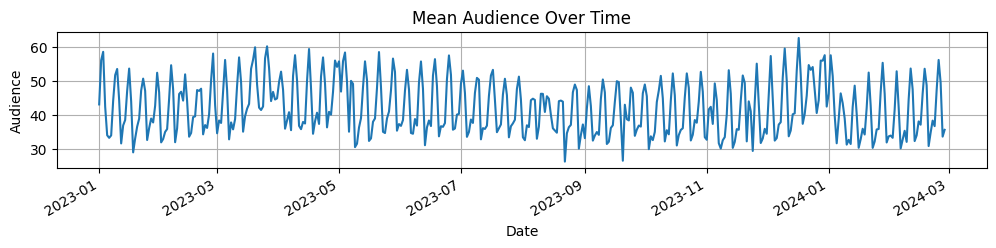

In [22]:
plt.figure(figsize=(12,2))
full.groupby('show_date')[target_col].mean().plot()
plt.title("Mean Audience Over Time")
plt.xlabel("Date")
plt.ylabel("Audience")
plt.grid(True)
plt.show()


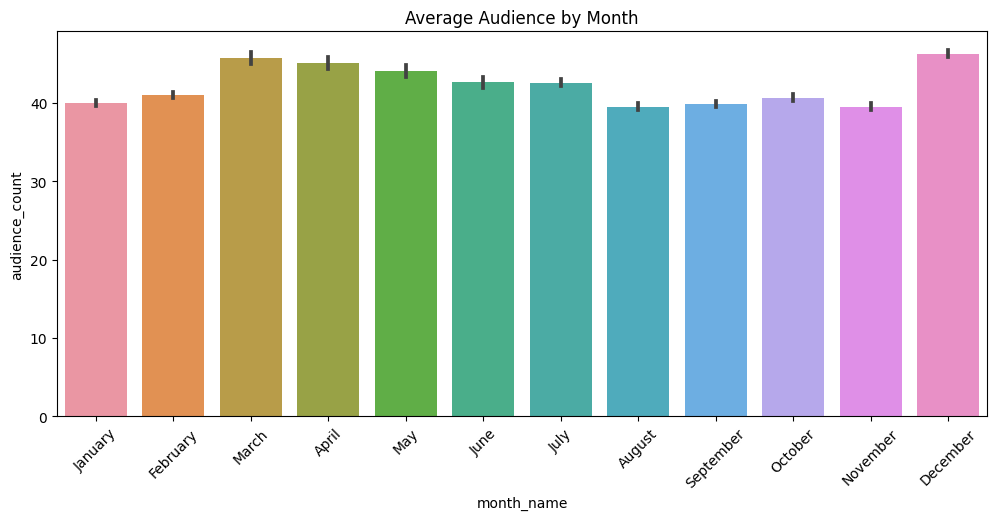

In [23]:
full['month_name'] = full['show_date'].dt.month_name()

month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

plt.figure(figsize=(12,5))
sns.barplot(x='month_name', y=target_col, data=full, order=month_order)
plt.title("Average Audience by Month")
plt.xticks(rotation=45)
plt.show()



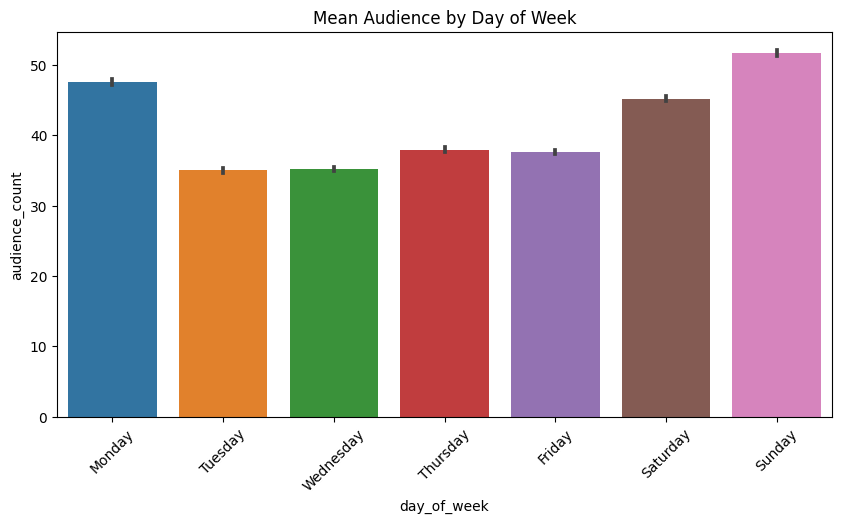

In [24]:

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.figure(figsize=(10,5))
sns.barplot(
    x='day_of_week', 
    y=target_col, 
    data=full, 
    order=order
)
plt.title("Mean Audience by Day of Week")
plt.xticks(rotation=45)
plt.show()


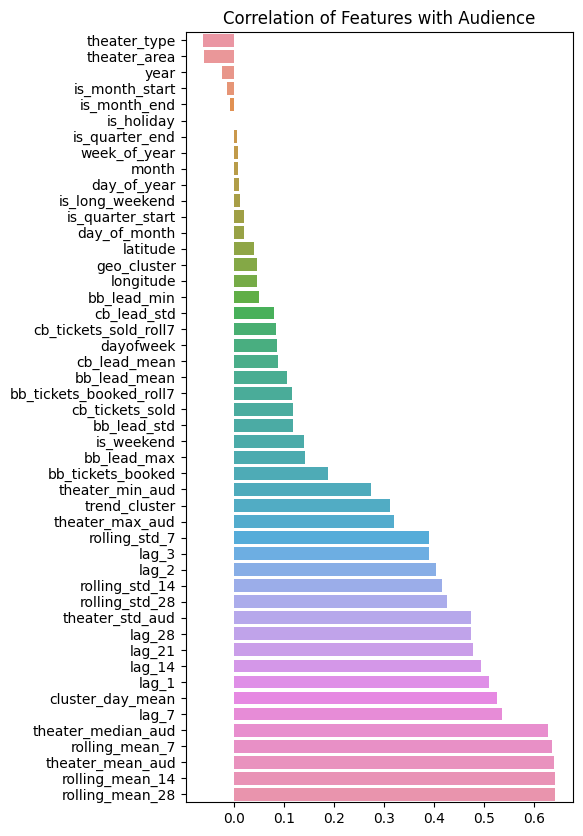

In [25]:
corr = num_cols.corr()[target_col].drop(target_col).sort_values()

plt.figure(figsize=(5,10))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Features with Audience")
plt.show()


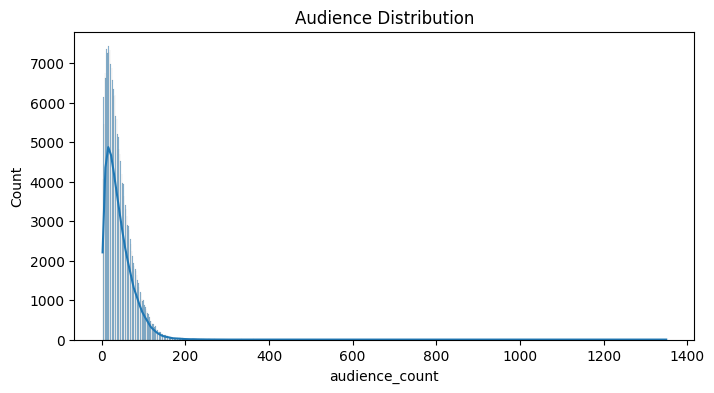

Skew: 2.6029173963703855


In [26]:
plt.figure(figsize=(8,4))
sns.histplot(full[target_col], kde=True)
plt.title("Audience Distribution")
plt.show()

print("Skew:", full[target_col].skew())


In [27]:
lag_cols = [c for c in full.columns if c.startswith("lag_")]
full[lag_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
lag_1,251990.0,41.179317,31.383916,2.0,18.0,34.0,56.0,1350.0
lag_2,251990.0,41.179071,31.383547,2.0,18.0,34.0,56.0,1350.0
lag_3,251990.0,41.179186,31.383411,2.0,18.0,34.0,56.0,1350.0
lag_7,251990.0,41.179507,31.382668,2.0,18.0,34.0,56.0,1350.0
lag_14,251990.0,41.178634,31.379730,2.0,18.0,34.0,56.0,1350.0
lag_21,251990.0,41.174324,31.363857,2.0,18.0,34.0,56.0,1350.0
lag_28,251990.0,41.170658,31.355841,2.0,18.0,34.0,56.0,1350.0


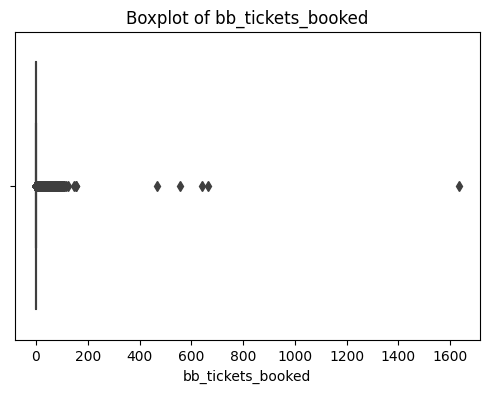

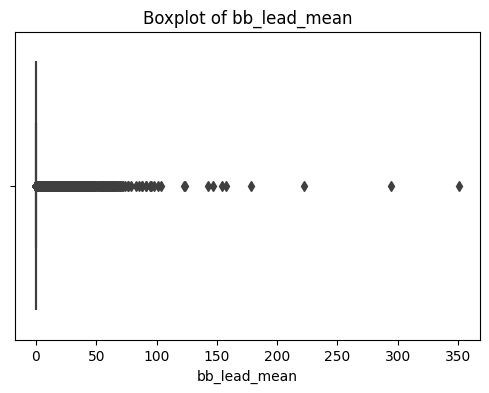

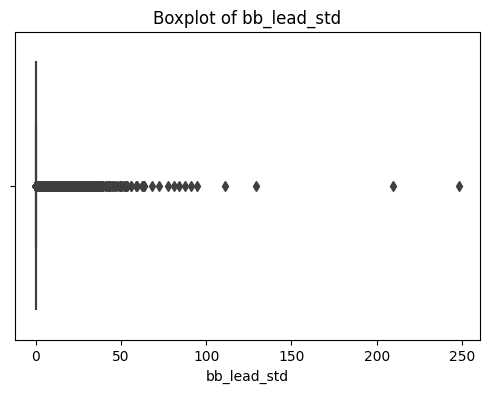

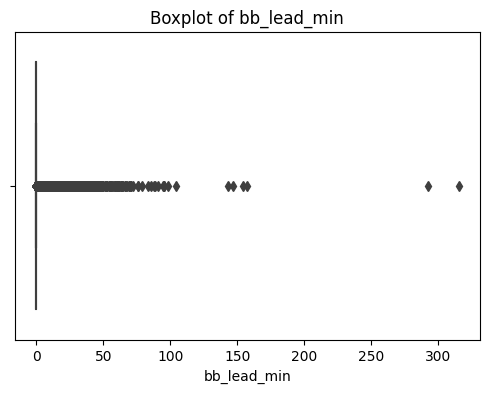

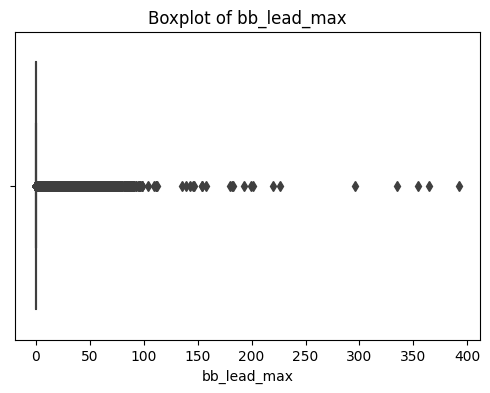

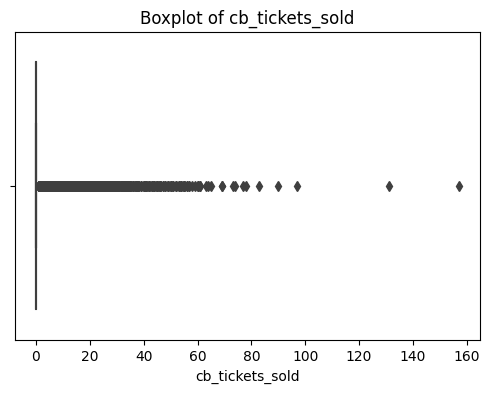

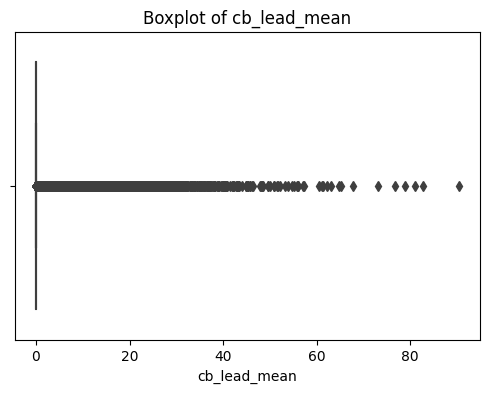

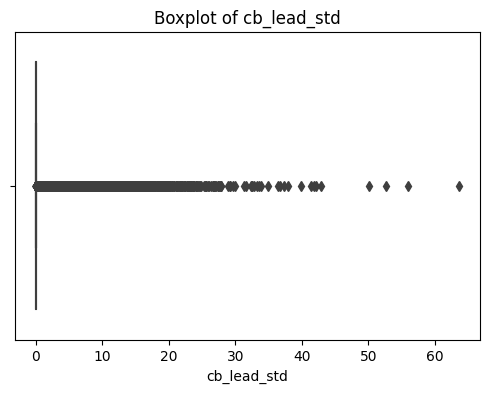

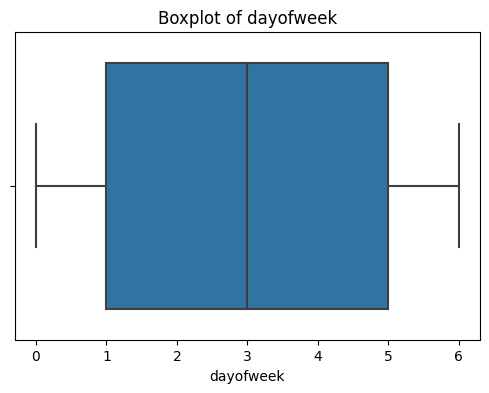

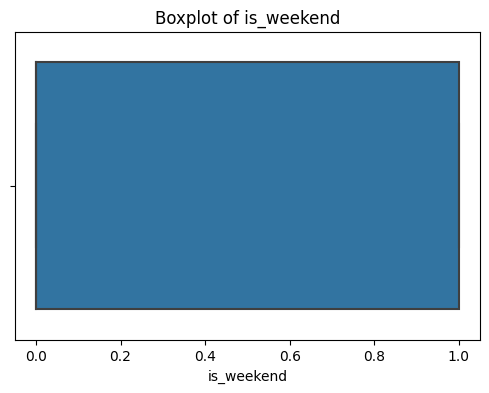

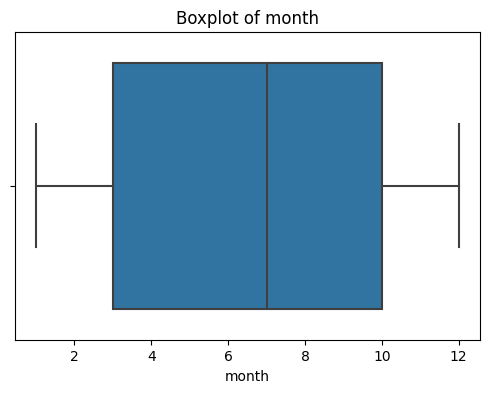

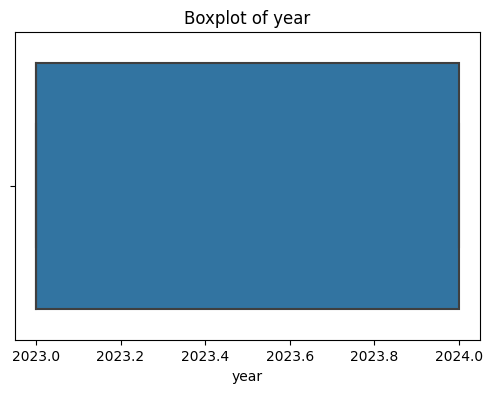

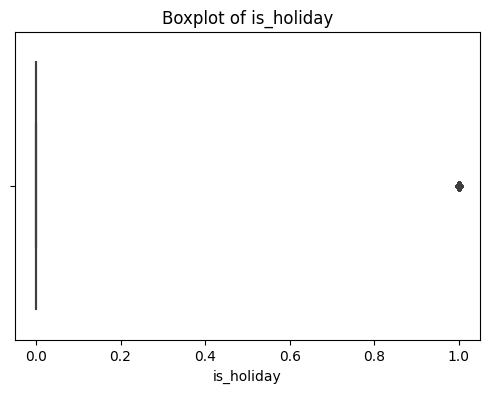

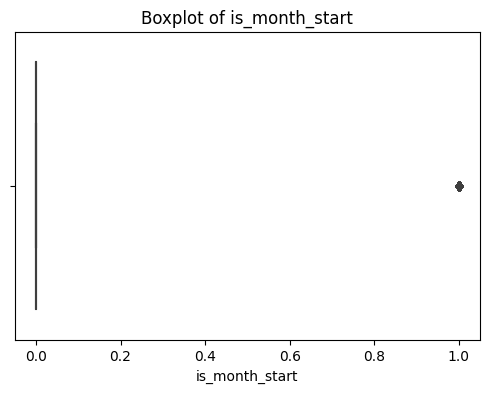

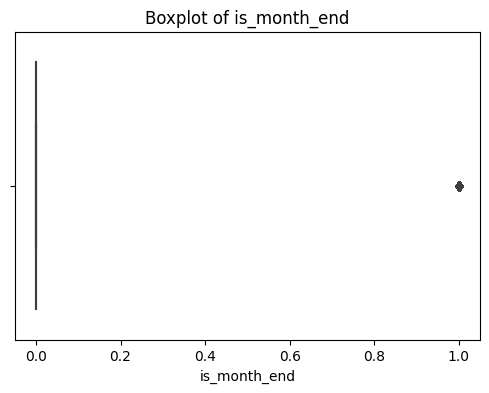

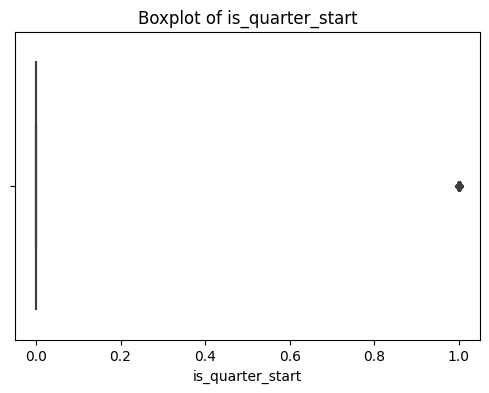

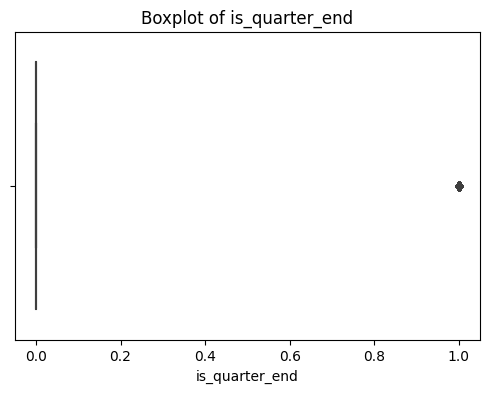

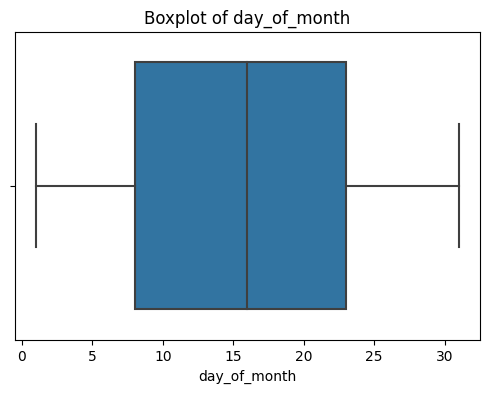

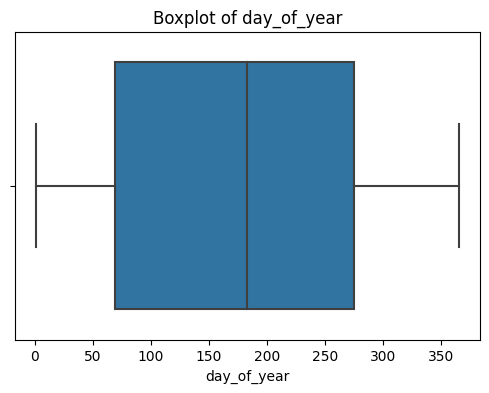

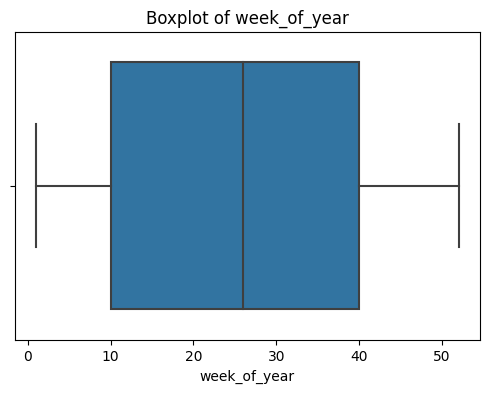

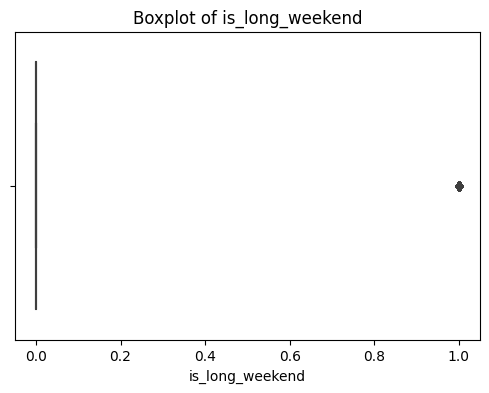

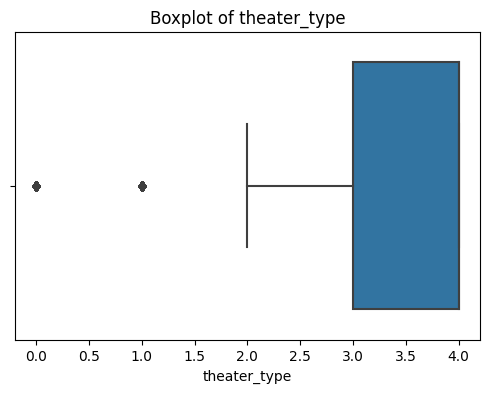

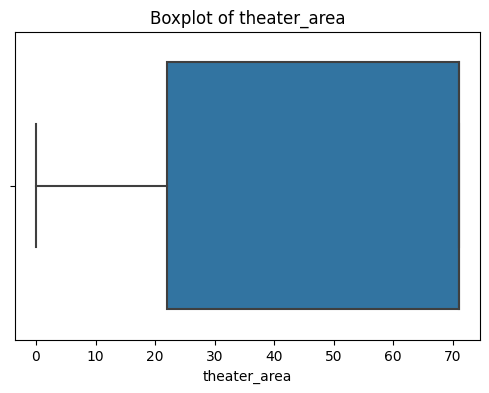

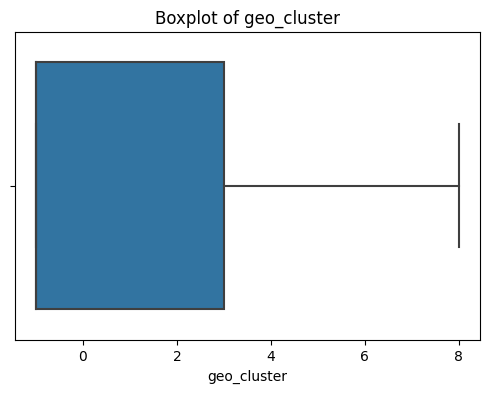

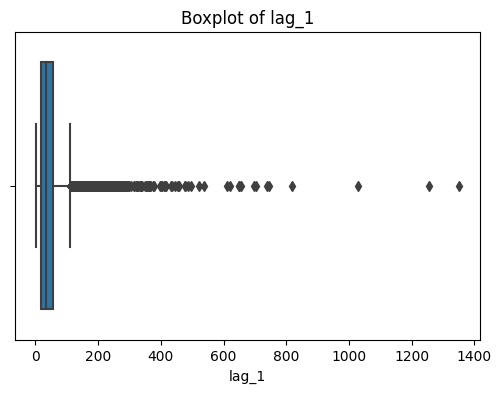

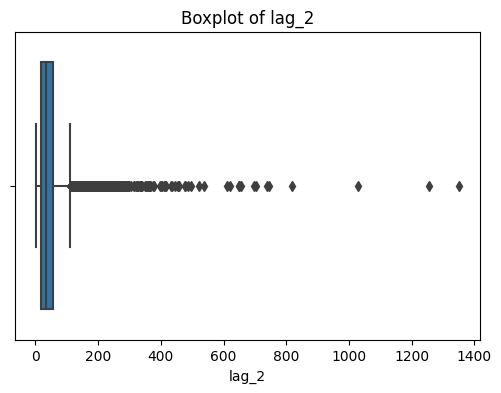

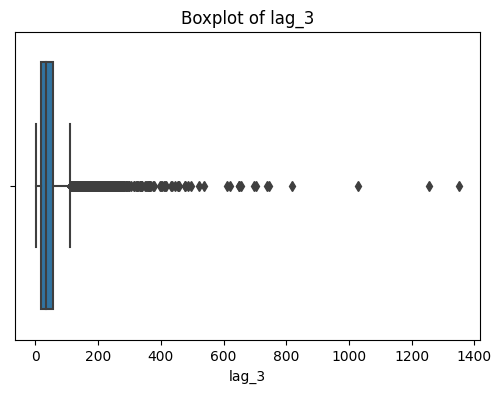

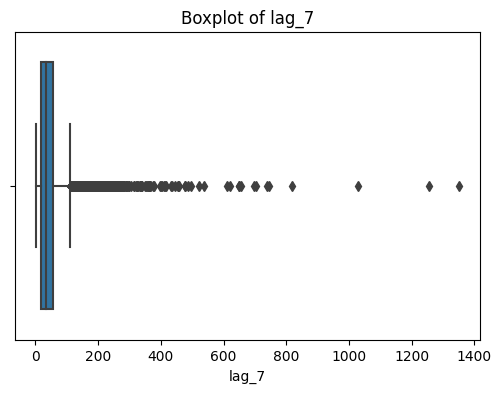

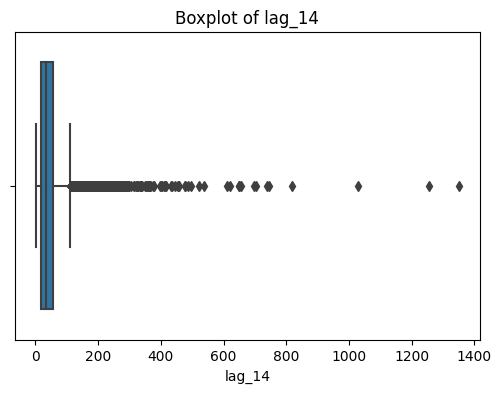

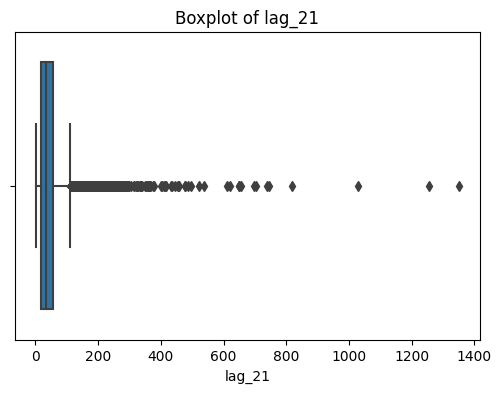

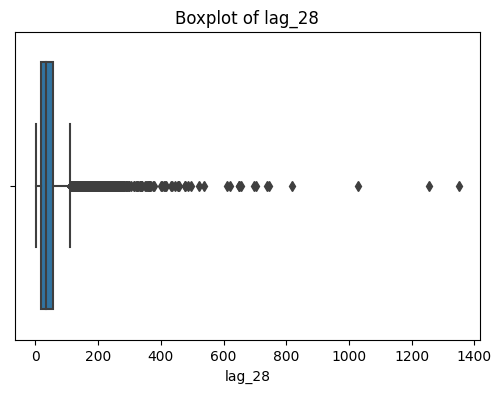

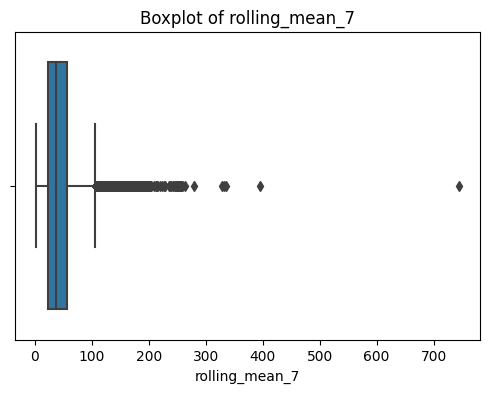

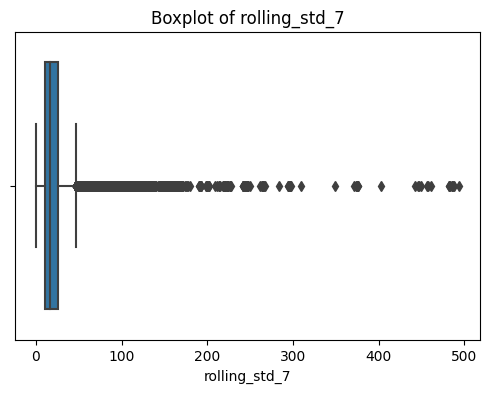

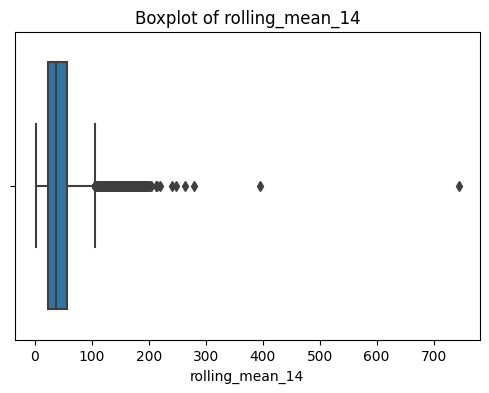

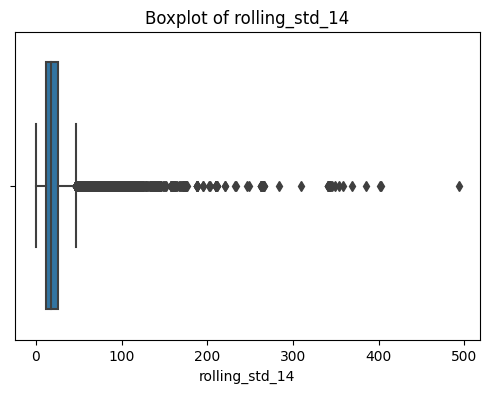

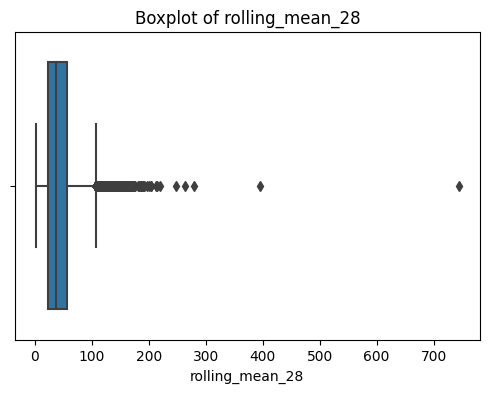

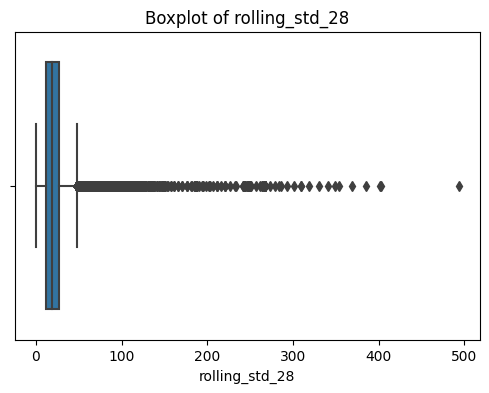

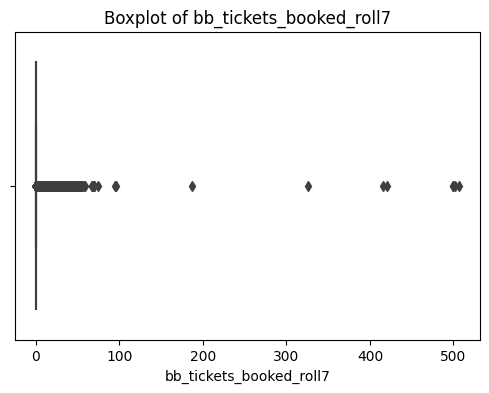

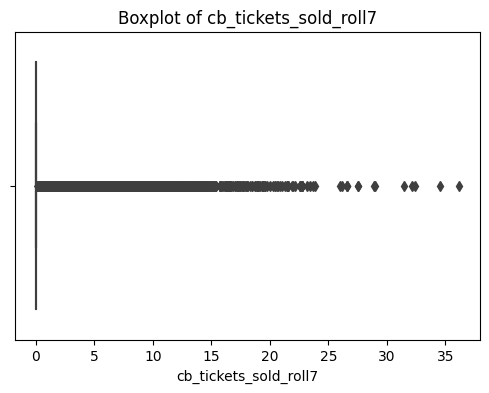

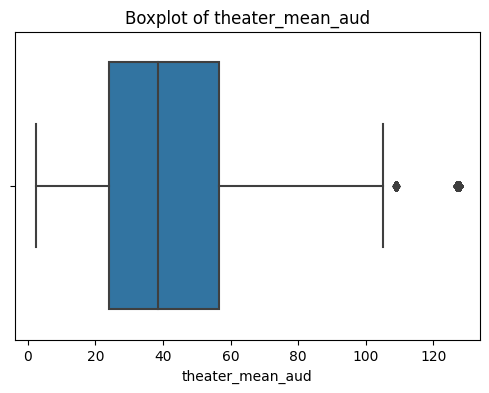

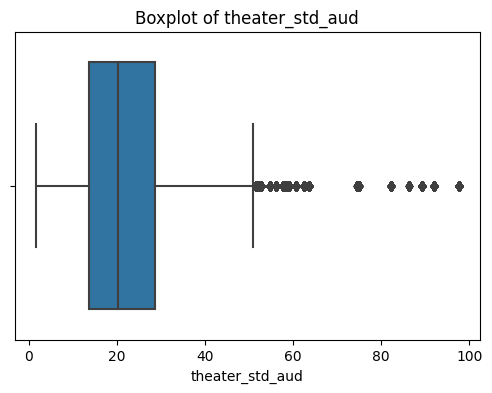

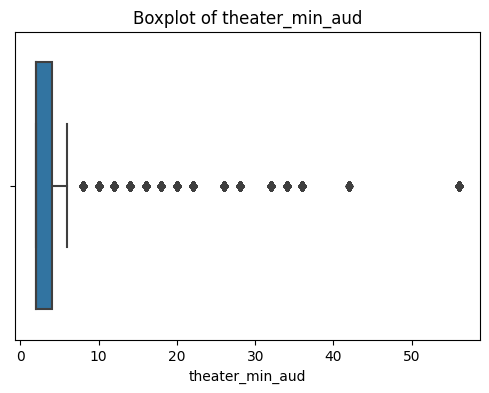

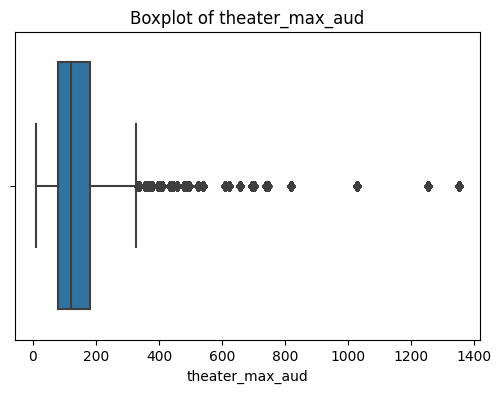

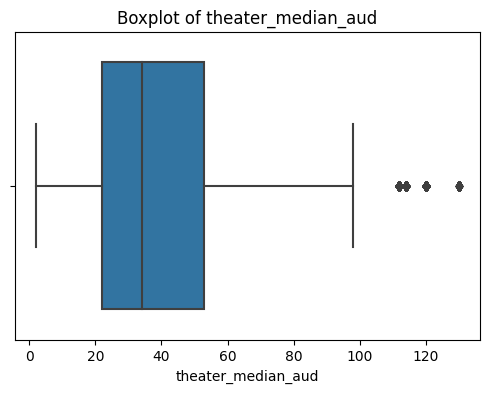

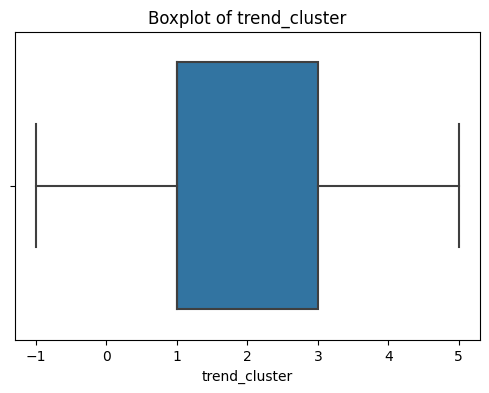

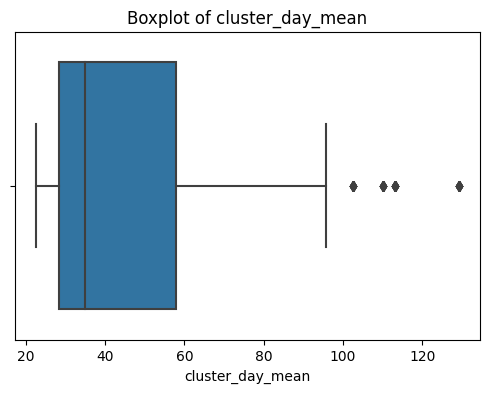

In [28]:
num_cols = [col for col in full.select_dtypes(include=['int8','int16','int64','float64']).columns if col!='audience_count']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=full[col])
    plt.title(f"Boxplot of {col}")
    plt.show()



# Train-Valid-Test Split

In [29]:
# TRAIN/VALID/TEST SPLIT -  last 30 days

train_mask = ~full[target_col].isna()
train_full = full[train_mask].copy()

val_days = 30  

def create_theater_val_mask(group):
    """For each theater, mark last val_days as validation"""
    if len(group) <= val_days:
        # If theater has very little data, use last 30% as validation
        val_size = max(1, int(len(group) * 0.3))
        group["is_val"] = False
        group.iloc[-val_size:, group.columns.get_loc("is_val")] = True
    else:
        max_date = group["show_date"].max()
        val_cutoff = max_date - pd.Timedelta(days=val_days)
        group["is_val"] = group["show_date"] > val_cutoff
    return group

train_full["is_val"] = False
train_full = train_full.groupby("book_theater_id", group_keys=False).apply(create_theater_val_mask)

train_df = train_full[~train_full["is_val"]].copy()
valid_df = train_full[train_full["is_val"]].copy()

# Test data: all rows from sample (those with NaN target)
test_mask = full[target_col].isna()
test_final = full[test_mask].copy()

print(f"Train rows: {len(train_df)} ({len(train_df['book_theater_id'].unique())} theaters)")
print(f"Valid rows: {len(valid_df)} ({len(valid_df['book_theater_id'].unique())} theaters)")
print(f"Test rows: {len(test_final)} ({len(test_final['book_theater_id'].unique())} theaters)")




drop_cols = ["show_date", "book_theater_id", target_col, "day_of_week",'year', 'latitude', 'longitude','dow', 'month_name']
feature_cols = [c for c in full.columns if c not in drop_cols]

# Encode book_theater_id with handling for unseen theaters
le_theater = LabelEncoder()
le_theater.fit(train_df["book_theater_id"].astype(str))

# Get all unique theater IDs across train/valid/test
all_theater_ids = pd.concat([
    train_df["book_theater_id"],
    valid_df["book_theater_id"],
    test_final["book_theater_id"]
]).unique()

# Create a mapping that includes unknown theaters
theater_mapping = {theater: idx for idx, theater in enumerate(le_theater.classes_)}
unknown_idx = len(theater_mapping)  # Assign unknown theaters to a new category

def safe_encode_theater(theater_id):
    """Encode theater ID, using unknown_idx for unseen theaters"""
    return theater_mapping.get(str(theater_id), unknown_idx)

train_df["theater_encoded"] = train_df["book_theater_id"].astype(str).apply(safe_encode_theater)
valid_df["theater_encoded"] = valid_df["book_theater_id"].astype(str).apply(safe_encode_theater)
test_final["theater_encoded"] = test_final["book_theater_id"].astype(str).apply(safe_encode_theater)


feature_cols.append("theater_encoded")

X_train = train_df[feature_cols]
X_valid = valid_df[feature_cols]
X_test = test_final[feature_cols]

y_train = train_df[target_col]
y_valid = valid_df[target_col]

Train rows: 192718 (825 theaters)
Valid rows: 21328 (826 theaters)
Test rows: 38062 (827 theaters)


In [30]:
X_train_rf = X_train.copy()
X_valid_rf = X_valid.copy()
X_test_rf  = X_test.copy()

num_cols = X_train_rf.select_dtypes(include='number').columns

for col in num_cols:
    med = X_train_rf[col].median()

    X_train_rf[col].fillna(med, inplace=True)
    X_valid_rf[col].fillna(med, inplace=True)
    X_test_rf[col].fillna(med, inplace=True)


In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192718 entries, 0 to 252037
Data columns (total 46 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   bb_tickets_booked        192718 non-null  float64
 1   bb_lead_mean             192718 non-null  float64
 2   bb_lead_std              192718 non-null  float64
 3   bb_lead_min              192718 non-null  float64
 4   bb_lead_max              192718 non-null  float64
 5   cb_tickets_sold          192718 non-null  float64
 6   cb_lead_mean             192718 non-null  float64
 7   cb_lead_std              192718 non-null  float64
 8   dayofweek                192718 non-null  int8   
 9   is_weekend               192718 non-null  int8   
 10  month                    192718 non-null  int8   
 11  is_holiday               192718 non-null  int64  
 12  is_month_start           192718 non-null  int8   
 13  is_month_end             192718 non-null  int8   
 14  is_quarte

In [32]:
X_train.select_dtypes(include=['object']).columns


Index([], dtype='object')

# Model Training

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train_rf, y_train)
rf_valid_pred = rf_model.predict(X_valid_rf)
print("Random Forest")
print("\nVALID R2:", r2_score(y_valid, rf_valid_pred))
print("VALID MAE:", mean_absolute_error(y_valid, rf_valid_pred))
print("VALID RMSE:", mean_squared_error(y_valid, rf_valid_pred, squared=False))

Random Forest

VALID R2: 0.5996567092188467
VALID MAE: 13.187435868382442
VALID RMSE: 19.640591446037483


In [34]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)
lgbm_valid_pred = lgbm_model.predict(X_valid)
print("Light GBM")
print("\nVALID R2:", r2_score(y_valid, lgbm_valid_pred))
print("VALID MAE:", mean_absolute_error(y_valid, lgbm_valid_pred))
print("VALID RMSE:", mean_squared_error(y_valid, lgbm_valid_pred, squared=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6411
[LightGBM] [Info] Number of data points in the train set: 192718, number of used features: 46
[LightGBM] [Info] Start training from score 41.788043
Light GBM

VALID R2: 0.5932601841975661
VALID MAE: 13.233445172387684
VALID RMSE: 19.79687442150105


In [35]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(
    max_depth=None,
    random_state=42
)

dt_model.fit(X_train_rf, y_train)
dt_valid_pred = dt_model.predict(X_valid_rf)
print("Decision Tree")
print("\nVALID R2:", r2_score(y_valid, dt_valid_pred))
print("VALID MAE:", mean_absolute_error(y_valid, dt_valid_pred))
print("VALID RMSE:", mean_squared_error(y_valid, dt_valid_pred, squared=False))

Decision Tree

VALID R2: 0.1154017823395026
VALID MAE: 19.60587021755439
VALID RMSE: 29.195190567764275


In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import pandas as pd
import numpy as np


param_grid = {
    "max_depth": randint(6, 12),
    "learning_rate": uniform(0.02, 0.03),    # narrow range
    "subsample": uniform(0.75, 0.20),
    "colsample_bytree": uniform(0.75, 0.20),
    "reg_alpha": uniform(0.0, 0.4),
    "reg_lambda": uniform(0.4, 0.6),
    "min_child_weight": randint(1, 6),
    "n_estimators": randint(400, 1500)
}

base_model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42
)




search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=10,               
    scoring="neg_mean_squared_error",
    cv=2,                    
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=100,
    verbose=False
)

xgb_model = search.best_estimator_

print("\nBest Params:\n", search.best_params_)
print("Best iteration:", xgb_model.best_iteration)



Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se


Best Params:
 {'colsample_bytree': 0.7649101287359542, 'learning_rate': 0.04960660809801552, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1047, 'reg_alpha': 0.00220884684944096, 'reg_lambda': 0.8892768570729005, 'subsample': 0.8913714687695234}
Best iteration: 446


# Evaluation

In [37]:
pred_train = xgb_model.predict(X_train)
pred_valid = xgb_model.predict(X_valid)

print("\nVALID R2:", r2_score(y_valid, pred_valid))
print("VALID MAE:", mean_absolute_error(y_valid, pred_valid))
print("VALID RMSE:", mean_squared_error(y_valid, pred_valid, squared=False))

#FEATURE IMPORTANCE
imp = xgb_model.get_booster().get_score(importance_type="gain")
imp_df = (pd.DataFrame.from_dict(imp, orient="index", columns=["gain"])
          .reset_index().rename(columns={"index": "feature"})
          .sort_values("gain", ascending=False))

print("\nTop 50 Features:")
print(imp_df.head(50))


VALID R2: 0.5938038851331096
VALID MAE: 13.197197330217119
VALID RMSE: 19.783638468037825

Top 50 Features:
                    feature           gain
32          rolling_mean_14  297258.437500
34          rolling_mean_28  269397.500000
38         theater_mean_aud  233940.421875
30           rolling_mean_7   90453.414062
9                is_weekend   89937.781250
0         bb_tickets_booked   56934.023438
42       theater_median_aud   45250.179688
44         cluster_day_mean   43883.832031
8                 dayofweek   39650.882812
43            trend_cluster   35646.792969
26                    lag_7   31003.142578
5           cb_tickets_sold   21454.775391
36  bb_tickets_booked_roll7   18930.978516
23                    lag_1   17985.203125
41          theater_max_aud   17964.742188
39          theater_std_aud   15304.004883
4               bb_lead_max   14532.955078
40          theater_min_aud   14158.015625
13             is_month_end   14019.044922
17              day_of_year   1

In [38]:
# PHASE 2 — FULL RETRAIN 

#take best parameters & overwrite n_estimators
best_params = search.best_params_.copy()
best_params["n_estimators"] = xgb_model.best_iteration + 1

full_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    tree_method="hist",
    random_state=42
)

X_full = pd.concat([X_train, X_valid], axis=0)
y_full = pd.concat([y_train, y_valid], axis=0)

full_model.fit(X_full, y_full)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7649101287359542, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04960660809801552,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=447, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#  Predict & build Submission


In [39]:
preds = full_model.predict(X_test)

preds_df = test_final[["book_theater_id", "show_date"]].copy()
preds_df["pred"] = preds

submission = sample.merge(
    preds_df, on=["book_theater_id","show_date"], how="left"
)

submission["audience_count"] = (
    submission["pred"].fillna(0).clip(lower=0).round().astype(int)
)

submission = submission[["ID","audience_count"]]
submission.to_csv("submission.csv", index=False)

print("\n✓ Saved submission.csv")


✓ Saved submission.csv


In [40]:
submission.head()

,ID,audience_count
0,book_00001_2024-03-01,33
1,book_00001_2024-03-02,49
2,book_00001_2024-03-03,54
3,book_00001_2024-03-04,49
4,book_00001_2024-03-06,34
